# Поиск изображений по описанию

<b>Задача:</b> Необходимо разработать демонстрационную версию поиска изображений по запросу. Для демонстрационной версии необходимо обучить модель, которая получит векторное представление изображения, векторное представление текста, а на выходе выдаст число от 0 до 1 — покажет, насколько текст и картинка подходят друг к другу.

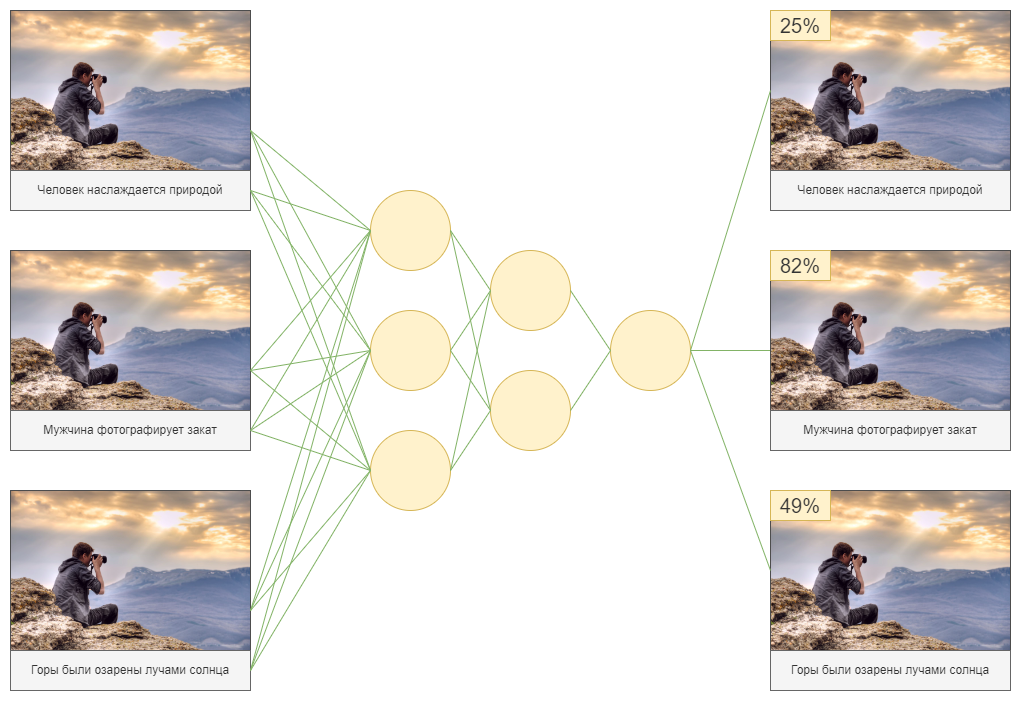

<b>Описание:</b> Пользователи компании «Со Смыслом» размещают свои фотографии на хостинге и сопровождают их полным описанием: указывают место съёмок, модель камеры и т.д. Отличительная особенность сервиса — описание: его может предоставить не только тот, кто размещает фотографию, но и другие пользователи портала. Отдел data science занимается экспериментом по разработке поиска референсных фотографий для фотографов. Суть поиска заключается в следующем: пользователь сервиса вводит описание нужной сцены, а сервис выводит несколько фотографий с такой же или похожей сценой. Чтобы эксперимент получил право на жизнь, нужно защитить его перед руководителем компании. Для защиты необходимо презентовать так называемый PoC (Proof of Concept, Проверка концепции) — продемонстрировать, что такой проект практически осуществим. Необходимо разработать демонстрационную версию поиска изображений по запросу.

<b>Юридические ограничения:</b> В некоторых странах, где работает компания With Sense, действуют ограничения по обработке изображений: поисковым сервисам и сервисам, предоставляющим возможность поиска, запрещено без разрешения родителей или законных представителей предоставлять любую информацию, в том числе, но не исключительно, текстов, изображений, видео и аудио, содержащие описание, изображение или запись голоса детей. Ребёнком считается любой человек, не достигший 16-ти лет. В вашем сервисе строго следуют законам стран, в которых работают. Поэтому необходимо очистить данные от проблемного контента.

---

In [1]:
# обработка данных
import pandas as pd
import numpy as np

# обработка текста
import torch
from transformers import DistilBertTokenizer, DistilBertModel
from tqdm import notebook

# обработка изображений
import cv2
from PIL import Image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50V2

# нейронная сеть
from keras.models import Sequential
from keras.layers import Dense, Dropout, GlobalAveragePooling2D
from keras import regularizers
from tensorflow.keras.optimizers import Adamax, Adam, Adagrad, Adadelta

# поиск оптимальных гиперпараметров
from scikeras.wrappers import KerasRegressor
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import mean_squared_error

# визуализация
%matplotlib inline
%config InlineBckend.figure_format = 'retina'
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
plt.style.use('seaborn-whitegrid')
mpl.rcParams['figure.figsize'] = (16,7)

import os
os.environ['CUDA_VISIBLE_DEVICES'] = '-1'
import warnings
warnings.filterwarnings('ignore')

In [2]:
# загружаем данные
train_dataset = pd.read_csv('train_dataset.csv')
test_dataset = pd.read_csv('test_queries.csv', sep='|').drop('Unnamed: 0', axis=1)

crowd_annotations = pd.read_csv('CrowdAnnotations.tsv', sep='\t', names=['jpg', 'description', 'percent', 'true', 'false'])
expert_annotations = pd.read_csv('ExpertAnnotations.tsv', sep='\t', names=['jpg', 'description', 'first', 'second', 'third'])

---

## Предварительный анализ данных

### Тренеровочный датасет

In [3]:
train_dataset

,image,query_id,query_text
0,1056338697_4f7d7ce270.jpg,2549968784_39bfbe44f9.jpg#2,A young child is wearing blue goggles and sitt...
1,1262583859_653f1469a9.jpg,2549968784_39bfbe44f9.jpg#2,A young child is wearing blue goggles and sitt...
2,2447284966_d6bbdb4b6e.jpg,2549968784_39bfbe44f9.jpg#2,A young child is wearing blue goggles and sitt...
3,2549968784_39bfbe44f9.jpg,2549968784_39bfbe44f9.jpg#2,A young child is wearing blue goggles and sitt...
4,2621415349_ef1a7e73be.jpg,2549968784_39bfbe44f9.jpg#2,A young child is wearing blue goggles and sitt...
...,...,...,...
5817,757046028_ff5999f91b.jpg,2061144717_5b3a1864f0.jpg#2,A man in an ampitheater talking to a boy .
5818,799486353_f665d7b0f0.jpg,2196107384_361d73a170.jpg#2,a old man walks down the uncrowded road .
5819,909808296_23c427022d.jpg,2112921744_92bf706805.jpg#2,A dog stands on the side of a grassy cliff .
5820,929679367_ff8c7df2ee.jpg,3651971126_309e6a5e22.jpg#2,A blurry photo of two dogs .


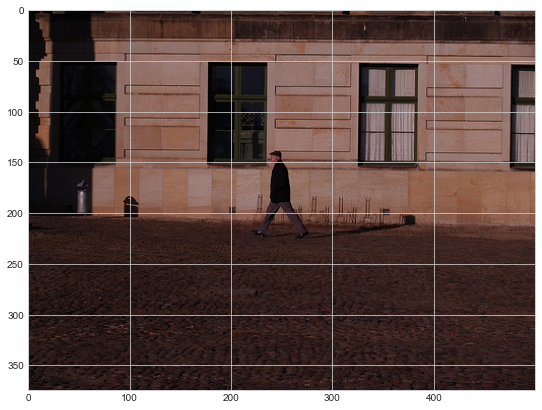

In [4]:
plt.imshow(Image.open(f'train_images/2196107384_361d73a170.jpg'));

<b>Комментарий:</b> Тренеровочный датасет содержит в себе множество фотографий с описаниями, где многие не подходят друг к другу. Для такого случая у нас есть рейтинги экспертов и краудсорсинга, которые помогут обработать данные.

---

### Тестовый датасет

In [5]:
test_dataset

,query_id,query_text,image
0,1177994172_10d143cb8d.jpg#0,"Two blonde boys , one in a camouflage shirt an...",1177994172_10d143cb8d.jpg
1,1177994172_10d143cb8d.jpg#1,Two boys are squirting water guns at each other .,1177994172_10d143cb8d.jpg
2,1177994172_10d143cb8d.jpg#2,Two boys spraying each other with water,1177994172_10d143cb8d.jpg
3,1177994172_10d143cb8d.jpg#3,Two children wearing jeans squirt water at eac...,1177994172_10d143cb8d.jpg
4,1177994172_10d143cb8d.jpg#4,Two young boys are squirting water at each oth...,1177994172_10d143cb8d.jpg
...,...,...,...
495,989851184_9ef368e520.jpg#0,A black dog has a dumbbell in his mouth .,989851184_9ef368e520.jpg
496,989851184_9ef368e520.jpg#1,A black dog has a dumbbell in his mouth lookin...,989851184_9ef368e520.jpg
497,989851184_9ef368e520.jpg#2,A black dog holding a weight in its mouth stan...,989851184_9ef368e520.jpg
498,989851184_9ef368e520.jpg#3,A black dog holds a small white dumbbell in it...,989851184_9ef368e520.jpg


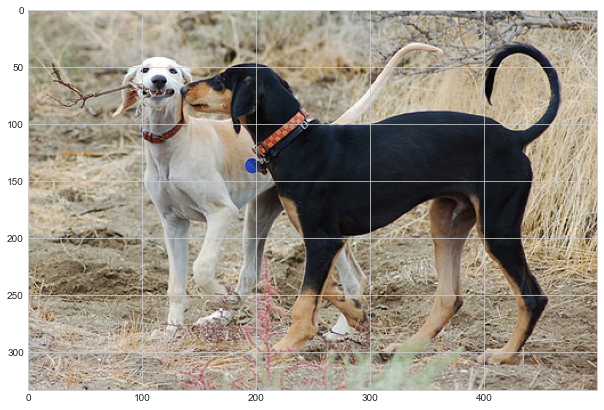

In [6]:
plt.imshow(Image.open(f'test_images/1429546659_44cb09cbe2.jpg'));

<b>Комментарий:</b> Тестовый датасет содержит в себя фотографии и пять правдоподобных описаний для каждой из них.

---

### Оценки Экспертов

In [7]:
expert_annotations

,jpg,description,first,second,third
0,1056338697_4f7d7ce270.jpg,2549968784_39bfbe44f9.jpg#2,1,1,1
1,1056338697_4f7d7ce270.jpg,2718495608_d8533e3ac5.jpg#2,1,1,2
2,1056338697_4f7d7ce270.jpg,3181701312_70a379ab6e.jpg#2,1,1,2
3,1056338697_4f7d7ce270.jpg,3207358897_bfa61fa3c6.jpg#2,1,2,2
4,1056338697_4f7d7ce270.jpg,3286822339_5535af6b93.jpg#2,1,1,2
...,...,...,...,...,...
5817,997722733_0cb5439472.jpg,2981702521_2459f2c1c4.jpg#2,1,1,1
5818,997722733_0cb5439472.jpg,2985679744_75a7102aab.jpg#2,1,1,1
5819,997722733_0cb5439472.jpg,3150742439_b8a352e1e0.jpg#2,1,1,2
5820,997722733_0cb5439472.jpg,3375070563_3c290a7991.jpg#2,1,1,1


<b>Комментарий:</b> Из-за необходимости платы экспертам, их оценок не так и много, но скорее всего, они будут являться первостепенными для оценки правдоподобия описания.

---

### Оценки краудсорсинга

In [8]:
crowd_annotations

,jpg,description,percent,true,false
0,1056338697_4f7d7ce270.jpg,1056338697_4f7d7ce270.jpg#2,1.000000,3,0
1,1056338697_4f7d7ce270.jpg,114051287_dd85625a04.jpg#2,0.000000,0,3
2,1056338697_4f7d7ce270.jpg,1427391496_ea512cbe7f.jpg#2,0.000000,0,3
3,1056338697_4f7d7ce270.jpg,2073964624_52da3a0fc4.jpg#2,0.000000,0,3
4,1056338697_4f7d7ce270.jpg,2083434441_a93bc6306b.jpg#2,0.000000,0,3
...,...,...,...,...,...
47825,997722733_0cb5439472.jpg,543007912_23fc735b99.jpg#2,0.000000,0,3
47826,997722733_0cb5439472.jpg,544576742_283b65fa0d.jpg#2,0.333333,1,2
47827,997722733_0cb5439472.jpg,872622575_ba1d3632cc.jpg#2,1.000000,3,0
47828,997722733_0cb5439472.jpg,888425986_e4b6c12324.jpg#2,0.000000,0,3


<b>Комментарий:</b> На краудсорсинге все бесплатно, поэтому мы имеем в разы больше оценок. Скорее всего, к ним необходимо относиться с настороженностью, ведь оценки ставили необученные люди.

---

## Обработка рейтинга

<b>Комментарий:</b> В файле с экспертными мнениями для каждой пары изображение-текст имеются оценки от трёх специалистов. Эксперты ставят оценки по шкале от 1 до 4, где:
- 1 — изображение и запрос совершенно не соответствуют друг другу;
- 2 — запрос содержит элементы описания изображения, но в целом запрос тексту не соответствует;
- 3 — запрос и текст соответствуют с точностью до некоторых деталей; 
- 4 — запрос и текст соответствуют полностью.

Необходимо эти оценки агрегировать. Для этого был выбран способ среднего, когда действительные оценки суммируются, а затем делятся на сумму максимально возможных баллов.

Важно заметить, что при полном несовпадении описания с картинкой, эксперты ставят единицу, что при расчетах будет давать тридцать процентов совпадения. Для избежания данной проблемы, необходимо вычесть три балла из всех оценок экспертов, тем самым сместив несовпадение к нулю.

In [9]:
# найдем процент, отвечающий за совпадение изображения и описания
expert_annotations['expert_percent'] = (expert_annotations[['first', 'second', 'third']].sum(axis=1) - 3) / 9

# соединим рейтинг экспертов и краудсорсинга в одну таблицу
rating = expert_annotations.merge(
    crowd_annotations[['jpg', 'description', 'percent']], how='left', on=['jpg', 'description']).fillna(0)

# задаем критерий доверия для экспертов 0.6 и краудсорсинга 0.4
rating['rating'] = np.round((rating['expert_percent'] * 0.6) + (rating['percent'] * 0.4), 2)
rating = rating[['jpg', 'description', 'rating']]

# соединим рейтинг с тренировочными данными
train_dataset = train_dataset.merge(
    rating[['jpg', 'description', 'rating']], how='left',
    left_on=['image', 'query_id'], right_on=['jpg', 'description'])[['image', 'query_text', 'rating']]; display(train_dataset)

,image,query_text,rating
0,1056338697_4f7d7ce270.jpg,A young child is wearing blue goggles and sitt...,0.00
1,1262583859_653f1469a9.jpg,A young child is wearing blue goggles and sitt...,0.00
2,2447284966_d6bbdb4b6e.jpg,A young child is wearing blue goggles and sitt...,0.13
3,2549968784_39bfbe44f9.jpg,A young child is wearing blue goggles and sitt...,1.00
4,2621415349_ef1a7e73be.jpg,A young child is wearing blue goggles and sitt...,0.00
...,...,...,...
5817,757046028_ff5999f91b.jpg,A man in an ampitheater talking to a boy .,0.40
5818,799486353_f665d7b0f0.jpg,a old man walks down the uncrowded road .,0.00
5819,909808296_23c427022d.jpg,A dog stands on the side of a grassy cliff .,0.20
5820,929679367_ff8c7df2ee.jpg,A blurry photo of two dogs .,0.33


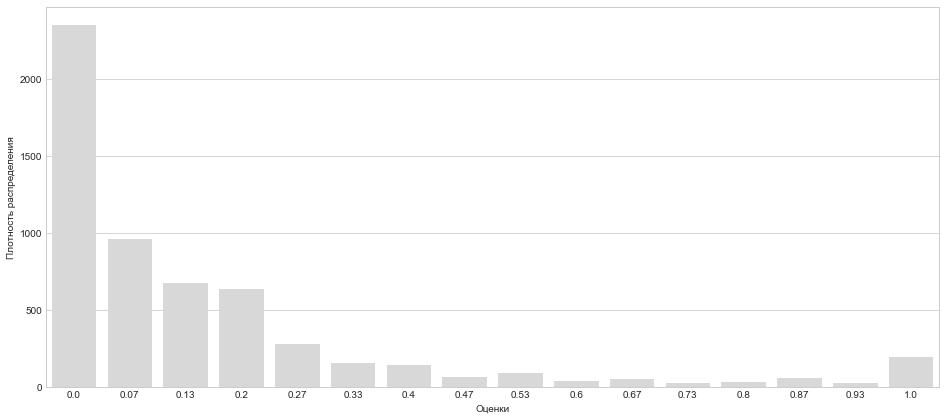

In [10]:
# построим график
chart = train_dataset[['rating']]; chart['count'] = 1
chart = chart.groupby(['rating'])['count'].sum().reset_index()

sns.barplot(data=chart[chart['count'] > 2], x='rating', y='count', color='#d8d8d8', label='Предсказание')
plt.ylabel('Плотность распределения')
plt.xlabel('Оценки');

<b>Комментарий:</b> Теперь датасет содержит процент соответствия описания к картинке. Как видно из графика, большинство картинок либо полностью не соответствуют описанию, либо очень отдаленно его напоминают.

---

## Обработка возраста

<b>Критерий заказчика:</b> В некоторых странах, где работает компания, действуют ограничения по обработке изображений: поисковым сервисам и сервисам, предоставляющим возможность поиска, запрещено без разрешения родителей или законных представителей предоставлять любую информацию, в том числе, но не исключительно тексты, изображения, видео и аудио, содержащие описание, изображение или запись голоса детей. Ребёнком считается любой человек, не достигший 16 лет. Все изображения, которые нарушают данный закон, нужно удалить из обучающей выборки.

In [11]:
# ключевые слова, описывающие детей
exceptions = ['young', 'child', 'children', 'baby',  'boy', 'boys', 'girl', 'girls', 'kid']

# найдем все упоминания о детях и удалим
def find_young(data):
    count = 0
    for index, value in enumerate(data['query_text']):
        for exc in exceptions:
            if exc in value:
                data = data.drop([index])
                count = count + 1
                break
    data = data.reset_index(drop=True)
    print(f'Были удалены: {count} детских фотографий')
    return data

train_dataset = find_young(train_dataset)
test_dataset = find_young(test_dataset)

Были удалены: 1551 детских фотографий
Были удалены: 159 детских фотографий


<b>Комментарий:</b> Для избавления от снимков, имеющих юридические сложности, был проведен поиск по ключевым словам, относящимся к детям и дальнейшее удаление подобных фотографий.

---

## Выбор порога доверия

Поскольку оставлять фотографии и описание к ним с низким рейтингом непозволительно для машинного обучения, необходимо выбрать порог доверия, благодаря которому останутся фотографии либо похожие на описание, либо полностью ему соответствующие.

Так, зная, что у трех экспертов оценка 3 - полное совпадение, а 2 частичное, минимальный порог для отсеивания составит: 

$$\frac{(2+2+2)}{9} * \frac{3}{5} = 0.4$$

Таким образом итоговый датасет будет включать в себя как минимум частичное совпадение, что обеспечит корректные ответы модели.

In [12]:
# утсановим порог доверия
train_dataset = train_dataset[train_dataset['rating'] >= 0.4].reset_index(drop=True); display(train_dataset)

,image,query_text,rating
0,1425069308_488e5fcf9d.jpg,A white dog jumps to catch a blue ball in a li...,1.00
1,2340206885_58754a799a.jpg,Two long-haired puppy dogs have a romp in the ...,0.53
2,3223224391_be50bf4f43.jpg,Two long-haired puppy dogs have a romp in the ...,0.40
3,2207244634_1db1a1890b.jpg,Snowboarder in the air performing a stunt .,0.40
4,3119076670_64b5340530.jpg,Snowboarder in the air performing a stunt .,1.00
...,...,...,...
632,3259991972_fce3ab18b2.jpg,A man stands on his head in front of a crowd .,0.93
633,447111935_5af98563e3.jpg,Two dark colored dogs romp in the grass with a...,0.53
634,3484832904_08619300d9.jpg,The cricketer is swinging a bat in the air .,0.67
635,3467219837_7d62213dec.jpg,Several dogs wearing muzzles are racing on a t...,1.00


---

## Векторизация текста

Для векторизации текста будет использована модель BERT.

In [13]:
# токенизатор
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')

# модель BERT
model = DistilBertModel.from_pretrained('distilbert-base-uncased') 

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_transform.weight', 'vocab_projector.weight', 'vocab_transform.bias', 'vocab_layer_norm.bias', 'vocab_layer_norm.weight', 'vocab_projector.bias']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [14]:
# токенизация и векторизация
def get_tokens(data):
    vectors = data['query_text'].apply(
        lambda x: tokenizer.encode(x, add_special_tokens=True, truncation=True))
    
    return vectors


tokenized_train = get_tokens(train_dataset)
tokenized_test = get_tokens(test_dataset)

In [15]:
# ищем самый длинный вектор
def max_length(data):
    max_len = 0
    for i in data.values:
        if len(i) > max_len:
            max_len = len(i)
            
    return max_len


max_len = pd.Series([max_length(tokenized_train), max_length(tokenized_test)]).max()

In [16]:
# добавляем нули, чтобы длинна векторов была одинаковой
def adding_zeros(data):
    vectors = np.array([i + [0]*(max_len - len(i)) for i in data.values])
    
    return vectors


padded_train = adding_zeros(tokenized_train)
padded_test = adding_zeros(tokenized_test)

In [17]:
# создаем маску
def get_mask(data):
    mask = np.where(data != 0, 1, 0)
    
    return mask


mask_train = get_mask(padded_train)
mask_test = get_mask(padded_test)

In [18]:
def get_bert_data(padded, attention_mask):
    
    batch_size = 8
    embeddings = []
    
    for i in notebook.tqdm(range(padded.shape[0] // batch_size)):
        # преобразуем данные
        batch = torch.LongTensor(padded[batch_size*i:batch_size*(i+1)])
        # преобразуем маску
        attention_mask_batch = torch.LongTensor(attention_mask[batch_size*i:batch_size*(i+1)])
        
        with torch.no_grad():
            batch_embeddings = model(batch, attention_mask=attention_mask_batch)
            
        # преобразуем элементы методом numpy() к типу numpy.array
        embeddings.append(batch_embeddings[0][:, 0, :].numpy())
        
    return np.concatenate(embeddings)
    
text_train = get_bert_data(padded_train, mask_train)
text_test = get_bert_data(padded_test, mask_test)

  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

In [19]:
pd.DataFrame(text_train)

,0,1,2,3,4,5,6,7,8,9,...,758,759,760,761,762,763,764,765,766,767
0,-0.252357,-0.395475,-0.106505,0.092546,0.055522,-0.137228,0.312985,0.513301,-0.257019,-0.233453,...,-0.256307,-0.068318,0.104002,0.048335,0.135134,0.104312,-0.060486,-0.146524,0.369875,0.306378
1,-0.186736,-0.226442,-0.044925,-0.016369,0.029264,-0.166028,0.351881,0.438543,-0.289424,-0.229057,...,-0.320236,-0.100192,-0.078127,-0.013547,0.149819,-0.010488,-0.130784,-0.198233,0.700588,0.249304
2,-0.186736,-0.226442,-0.044925,-0.016369,0.029264,-0.166028,0.351881,0.438543,-0.289424,-0.229057,...,-0.320236,-0.100192,-0.078127,-0.013547,0.149819,-0.010488,-0.130784,-0.198233,0.700588,0.249304
3,-0.383569,-0.388146,-0.321456,0.029270,-0.102108,-0.288716,0.425772,0.638665,-0.271384,-0.156895,...,-0.189028,-0.198356,0.221138,-0.170908,0.220460,0.028764,0.074233,-0.365457,0.531528,-0.003626
4,-0.383569,-0.388146,-0.321456,0.029270,-0.102108,-0.288716,0.425772,0.638665,-0.271384,-0.156895,...,-0.189028,-0.198356,0.221138,-0.170908,0.220460,0.028764,0.074233,-0.365457,0.531528,-0.003626
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
627,-0.011298,-0.048539,-0.037850,-0.219075,0.045106,-0.092548,0.148513,0.599027,-0.336798,-0.347633,...,-0.173114,-0.322077,0.092853,0.098607,-0.047388,-0.041246,-0.152944,-0.085333,0.489234,0.115607
628,-0.362448,-0.517590,-0.082780,-0.014711,-0.116976,-0.261700,0.316263,0.686216,-0.445903,-0.143831,...,-0.142004,-0.192130,0.193079,0.019081,0.180011,-0.058810,0.025942,-0.115005,0.375628,0.304819
629,-0.005040,-0.139491,0.060882,0.009469,0.100433,-0.076345,0.103614,0.487302,-0.278356,-0.281597,...,-0.086175,-0.133283,-0.020221,-0.061654,-0.007236,0.152745,-0.085954,-0.152875,0.269410,0.151433
630,-0.145806,-0.536488,-0.520050,-0.064939,-0.035671,0.111569,-0.214287,1.149240,-0.439232,-0.489818,...,-0.324405,-0.242716,-0.031298,-0.071591,0.207256,0.033056,0.008569,-0.309819,0.704643,-0.125365


<b>Комментарий:</b> Пройдя путь обработки, текст превратися из букв в вектор. Один из этапов предобработки данных закончен.

---

## Векторизация изображений
Для векторизации изображений необходимо прочитать все файлы из папок при помощи datagen, а затем обучить, ну или же использовать, как в нашем случае, уже предобученную сеть без выходных слоев с GlobalAveragePooling2D.

In [20]:
# загружаем изображения из папок и датафреймов
datagen = ImageDataGenerator(rescale=1/255)

train_datagen_flow = datagen.flow_from_dataframe(
    dataframe=train_dataset[['image', 'query_text']],
    directory='train_images/',
    x_col='image',
    y_col='query_text',
    target_size=(224, 224),
    batch_size=1,
    class_mode=None,
    seed=21)

test_datagen_flow = datagen.flow_from_dataframe(
    dataframe=test_dataset[['image', 'query_text']],
    directory='test_images/',
    x_col='image',
    y_col='query_text',
    target_size=(224, 224),
    batch_size=1,
    class_mode=None,
    seed=21)

Found 637 validated image filenames.
Found 341 validated image filenames.


<b>Комментарий:</b> Для векторизации изображений возьмем готовую модель ResNet50 версии 2 с весами от imagenet и отключим выходные слои. Чтобы в итоге получить вектор, необходимо в конец поставить слой GlobalAveragePooling2D. Сама структура ResNet50 состоит из нескольких, идущих подряд сверточных слоев одной размерности и pooling слой, затем ее сменяют такие же сверточные слои, но другой размерности, а в конце можно найти слои Average Pooling, Dense и Softmax, которые мы преднамеренно отключаем, чтобы получить вектор.

Так вот данная модель использует небольшой трюк со сверточными слоями. Чем больше фильтр, тем лучше живется нашей модели, но если увеличивать фильтр, то число настраиваемых коэффициентов сильно увеличивается. Для этого придумали метод двойных или тройных фильтров. На примере с двойными: когда подряд идут два сверточных слоя с фильтрами 3x3, последний из них хоть и имеет такой же фильтр, но анализирует площадь 5x5.
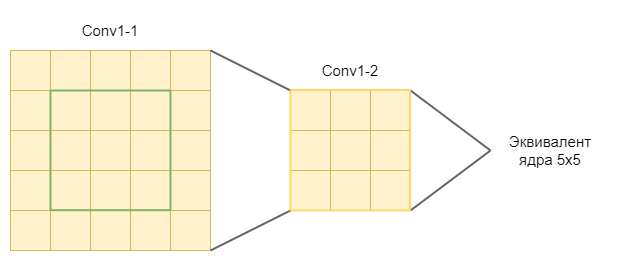

Если посчитать математически, то фильтр 5x5 будет равен (5 * 5 + 1) = 26 настраиваемых параметров. А если взять два фильтра с размером ядра 3x3, то число настраиваемых коэффициентов будет всего (3 * 3 + 1) * 2 = 20.

Интересно знать, что для цветных изображений каждый цвет обрабатывается своим фильтром и создает свою карту признаков, из-за чего мы используем размерность (x, y, 3) 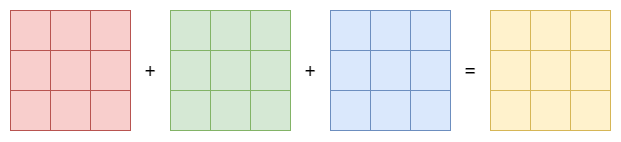

In [21]:
# создаем модель для преобразования изображений в векторы
model = Sequential()
model.add(ResNet50V2(input_shape=(224, 224, 3), weights='imagenet', include_top=False))
model.add(GlobalAveragePooling2D())

model.compile(loss='mse', optimizer='adam', metrics=['mae'])

In [22]:
# векторизируем все изображения
photo_train = []
photo_test = []

def photo_vectorizer(data, x):
    for index in range(data):
        feature = next(train_datagen_flow)
        x.append(model(feature, training=False))
        
photo_vectorizer(train_dataset.shape[0], photo_train)
photo_vectorizer(test_dataset.shape[0], photo_test)

In [23]:
# функция объединяет векторы изображений в один датафрейм (N x M)
def get_concat(datagen, vector):
    data = pd.concat([pd.DataFrame(), pd.DataFrame(vector[0])], ignore_index=True)
    for index in range(datagen.samples - 1):
        data = pd.concat([data, pd.DataFrame(vector[index + 1])], ignore_index=True)
    return data

photo_train = get_concat(train_datagen_flow, photo_train)
photo_test = get_concat(test_datagen_flow, photo_test)

display(photo_train)

,0,1,2,3,4,5,6,7,8,9,...,2038,2039,2040,2041,2042,2043,2044,2045,2046,2047
0,0.000000,1.562367,0.105680,0.000000,0.038809,0.0,0.154740,0.153614,0.555265,0.624822,...,0.000000,0.236726,0.015002,0.000000,0.000000,0.030184,1.013592,0.000000,0.037851,0.000000
1,0.063444,0.000000,0.000000,0.652977,0.000000,0.0,0.698150,0.544933,0.681562,0.000000,...,0.188437,0.172384,0.054748,0.000000,0.038452,0.133153,0.601057,0.000000,0.780490,0.470595
2,0.000000,0.000000,0.599017,0.037601,0.004691,0.0,2.105936,0.168138,0.057960,0.998756,...,0.000000,0.000000,0.024047,0.000000,0.000000,0.638323,0.107041,0.029269,2.670530,0.002701
3,0.028222,0.282121,0.127692,0.187793,0.008975,0.0,0.401813,0.000000,0.001629,0.506554,...,0.000000,0.113338,1.037278,0.000000,0.000000,0.004127,1.058905,0.006170,0.096984,0.000000
4,0.000000,0.000000,0.070303,2.112875,0.227076,0.0,7.553753,0.361116,0.668866,0.043760,...,0.000000,0.000000,0.000000,0.000000,0.246804,0.000000,2.194914,0.258900,0.168400,0.027743
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
632,0.061378,0.000000,0.401271,0.000000,0.092395,0.0,1.222981,0.000000,0.018966,0.237257,...,0.000000,0.026300,1.948809,0.000000,0.000235,0.050309,1.390280,0.000000,0.155408,0.000000
633,0.003568,0.013505,0.161060,0.000000,0.270392,0.0,0.916449,0.106389,0.201277,0.000000,...,0.000000,0.000000,0.735918,0.000000,0.027816,0.000000,0.564980,0.000000,0.000000,0.000000
634,0.000000,0.059742,1.196678,8.279100,0.025800,0.0,0.119346,0.000000,0.501654,0.292179,...,0.648842,0.000000,0.465732,0.002156,0.000000,0.044426,0.887595,0.004710,0.000000,4.854028
635,0.000000,0.059742,1.196678,8.279100,0.025800,0.0,0.119346,0.000000,0.501654,0.292179,...,0.648842,0.000000,0.465732,0.002156,0.000000,0.044426,0.887595,0.004710,0.000000,4.854028


---

## Объединение векторов

Подготовим данные для обучения, путем объединения вектора текста и изображения

In [24]:
# train
features_train = pd.DataFrame(text_train).join(photo_train, lsuffix='text', rsuffix='photo')
target_train = train_dataset['rating'][:features_train.shape[0]]

In [25]:
# test
features_test = pd.DataFrame(text_test).join(photo_test[:text_test.shape[0]], lsuffix='text', rsuffix='photo')

---

## Обучение модели предсказания соответствия

<b>Комментарий:</b> Для обучения необходимо разделить датасет на тренировочную и тестовую выборки. Простое случайное разбиение не подходит: нужно исключить попадание изображения и в обучающую, и в тестовую выборки. Для того чтобы учесть изображения при разбиении, можно воспользоваться классом GroupShuffleSplit из библиотеки sklearn.model_selection.

In [26]:
from sklearn.model_selection import GroupShuffleSplit
gss = GroupShuffleSplit(n_splits=1, train_size=.7, random_state=21)

train_indices, test_indices = next(gss.split(X=features_train, y=target_train, groups=train_dataset['image'][:features_train.shape[0]]))

features_train, features_valid = features_train.loc[train_indices], features_train.loc[test_indices]
target_train, target_valid = target_train.loc[train_indices], target_train.loc[test_indices]

<b>Комментарий:</b> Поскольку нам недопустимо иметь редкие, но большие ошибки, необходимо использовать функцию потерь MSE. Также она двигается к минимуму функции в разы быстрее MAE за счет квадрата.
$$E = \frac{1}{N} \sum^N_{i=1} (d_i - y_i)^2$$

Оптимизатором же является Adam, как усовершенствованная версия Adagrad’a. Adam: использует сглаженные версии среднего (m) и среднеквадратического (v) градиента.
$$m_t = \beta_1m+(1-\beta_1)\cdot g_t \\ v_t=\beta_2+(1-\beta_2)\cdot g_t^2 \\ u_t=-\frac{\eta}{\sqrt{v+e}}\cdot m_t$$

Функцией активации будет выступать Leaky ReLU, так как мы имеем множество отрицательных значений в обучающей выборке.

$$LeakyReLU(x)=max(0.1⋅x,x)$$

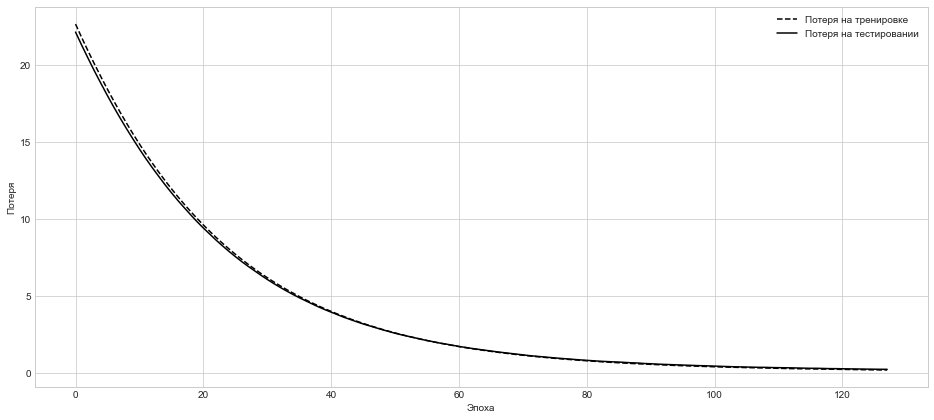

In [27]:
# спроектируем полносвязную нейронную сеть
model = Sequential()
model.add(Dense(units=1024, activation='LeakyReLU', kernel_regularizer=regularizers.L2(0.01)))
model.add(Dense(units=512, activation='LeakyReLU', kernel_regularizer=regularizers.L2(0.01)))
model.add(Dense(units=64, activation='LeakyReLU', kernel_regularizer=regularizers.L2(0.01)))
model.add(Dense(units=1, activation='sigmoid'))

model.compile(loss='mse', optimizer=Adam(0.0001), metrics=['mse'])

history = model.fit(features_train, target_train,
                    validation_data=(features_valid, target_valid),
                    epochs=128, batch_size=64, verbose=False)

# Получаем историю потерь
training_loss = history.history['loss']
test_loss = history.history['val_loss']
epoch_count = range(0, len(training_loss))

# Визуализация истории потерь
plt.plot(epoch_count, training_loss, 'k--')
plt.plot(epoch_count, test_loss, 'k-')
plt.legend(['Потеря на тренировке', 'Потеря на тестировании'])
plt.xlabel('Эпоха')
plt.ylabel('Потеря')
plt.show();

---

## Тестирование модели
<b>Комментарий:</b> Итоговым шагом является предсказание. По условиям заказчика, необходимо вывести 10 случайных фотографий, определить для них релевантное описание и сделать вывод.

In [28]:
predictions = pd.DataFrame(model.predict(features_test))

test_data = test_dataset; test_data['predictions'] = predictions

11/11 [==============================] - 0s 4ms/step


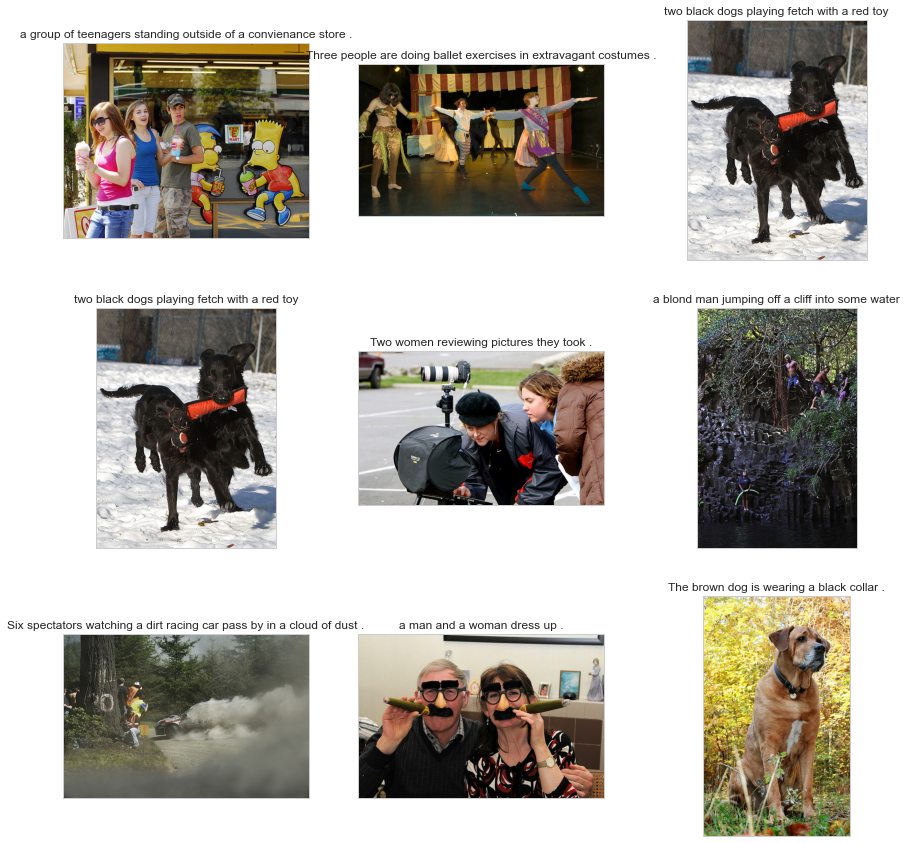

In [29]:
plt.figure(figsize=(15, 15))
for index, images in enumerate(test_data['image'].sample(n=9)):
    answer = test_data[test_data['image'] == f'{images}'].max()['query_text']
    plt.subplot(3, 3, index+1)
    plt.xticks([])
    plt.yticks([])
    plt.title(f'{answer}')
    plt.imshow(Image.open(f'test_images/{images}'), cmap=plt.cm.binary)
    

plt.show()

---

<b>Вывод:</b> Все девять фотографий подходят под описание, что говорит об успешности моделей векторизации и предсказания. Вначале было довольно сложно разобраться с данными, так как они были запутанны, но в итоге удалось векторизовать текст и фотографии, объединив их в одно целое. Также за все время предсказаний я не нашел ни одного ребенка на фотографии, что позволяет компании пройти под юридическими ограничениями. По итогам обучения модели, получились достойные результаты, которые позволяют отправить проект заказчику.